In [1]:

# Necessary Imports
import os, requests, torch, math, cv2, sys, PIL, argparse, dlib,imutils, time, json
import numpy as np
from PIL import Image
from datetime import datetime
from typing import List, Optional
from imutils.video import VideoStream
from imutils.video import FPS

# Imports for YoloV6 for Object Detection
from YOLOv6 import yolov6
sys.modules['yolov6'] = yolov6

from YOLOv6.yolov6.utils.events import LOGGER, load_yaml
from YOLOv6.yolov6.layers.common import DetectBackend
from YOLOv6.yolov6.data.data_augment import letterbox
from YOLOv6.yolov6.utils.nms import non_max_suppression
from YOLOv6.yolov6.core.inferer import Inferer

# Imports for Object Reidentification 
from deep_person_reid import torchreid
sys.modules['torchreid'] = torchreid
from deep_person_reid.torchreid.utils import FeatureExtractor



In [2]:
cuda = torch.cuda.is_available()
device = torch.device('cuda' if cuda else 'cpu')


class_names = [ 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
         'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
         'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
         'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
         'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
         'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
         'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
         'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear',
         'hair drier', 'toothbrush' ]
         

In [3]:

def check_img_size(img_size, s=32, floor=0):
    def make_divisible( x, divisor):
      # Upward revision the value x to make it evenly divisible by the divisor.
      return math.ceil(x / divisor) * divisor
    """Make sure image size is a multiple of stride s in each dimension, and return a new shape list of image."""
    if isinstance(img_size, int):  # integer i.e. img_size=640
        new_size = max(make_divisible(img_size, int(s)), floor)
    elif isinstance(img_size, list):  # list i.e. img_size=[640, 480]
        new_size = [max(make_divisible(x, int(s)), floor) for x in img_size]
    else:
        raise Exception(f"Unsupported type of img_size: {type(img_size)}")

    if new_size != img_size:
        print(f'WARNING: --img-size {img_size} must be multiple of max stride {s}, updating to {new_size}')
    return new_size if isinstance(img_size,list) else [new_size]*2


In [4]:

def precess_image(path, img_size, stride):
    
    '''Process image before image inference.'''
        
    try:
        from PIL import Image
        if type(path) == str:
            img_src = np.asarray(Image.open(path))
        else:
            img_src = path
        assert img_src is not None, f'Invalid image: {path}'
        
    except Exception as e:
        LOGGER.Warning(e)
        
    image = letterbox(img_src, img_size, stride=stride)[0]

    # Convert
    image = image.transpose((2, 0, 1))[::-1]  # HWC to CHW, BGR to RGB
    image = torch.from_numpy(np.ascontiguousarray(image))
    image = image.float()  # uint8 to fp16/32
    image /= 255  # 0 - 255 to 0.0 - 1.0

    return image, img_src


In [5]:
model = DetectBackend(f"models/yolov6l.pt", device=device)
stride = model.stride
class_names = load_yaml("YOLOv6/data/coco.yaml")['names']

model.model.float()

img_size = (640,640)
if device.type != 'cpu':
    model(torch.zeros(1, 3, *img_size).to(device).type_as(next(model.model.parameters())))  # warmup

print("DONE")

Loading checkpoint from models/yolov6l.pt

Fusing model...


DONE


In [6]:
def detect(image):

    hide_labels: bool = False 
    hide_conf: bool = False 

    img_size:int = 640

    conf_thres: float =.25
    iou_thres: float =.45
    max_det:int =  1000
    agnostic_nms: bool = False 

    img_size = check_img_size(img_size, s=stride)

    img, img_src = precess_image(image, img_size, stride)
    img = img.to(device)
    if len(img.shape) == 3:
        img = img[None]
        # expand for batch dim
    pred_results = model(img)
    classes:Optional[List[int]] = None # the classes to keep
    det = non_max_suppression(pred_results, conf_thres, iou_thres, classes, agnostic_nms, max_det=max_det)[0]

    gn = torch.tensor(img_src.shape)[[1, 0, 1, 0]]  # normalization gain whwh
    img_ori = img_src.copy()
    if len(det):
        det[:, :4] = Inferer.rescale(img.shape[2:], det[:, :4], img_src.shape).round()
    return det


In [7]:

def draw_text(img, text,
          pos=(0, 0),
          font=cv2.FONT_HERSHEY_PLAIN,
          font_scale=3,
          text_color=(0, 255, 0),
          font_thickness=2,
          text_color_bg=(0, 0, 0)
          ):

    x, y = pos
    font_scale = 1
    font = cv2.FONT_HERSHEY_PLAIN
    text_size, _ = cv2.getTextSize(text, font, font_scale, font_thickness)
    text_w, text_h = text_size
    cv2.rectangle(img, (x, y - text_h - 10), (x + text_w + 10, y), text_color_bg, -1)
    cv2.putText(img, text, (x+5, y-5), font, font_scale, text_color, font_thickness)


def draw_bb_text(frame, text,
          bbox,
          font=cv2.FONT_HERSHEY_PLAIN,
          font_scale=3,
          text_color=(0, 255, 0),
          font_thickness=2,
          color_bg=(255, 255, 255)
          ):

    startX, startY, endX, endY = bbox
    text_size, _ = cv2.getTextSize(text, font, font_scale, font_thickness)
    text_w, text_h = text_size
    startY = 20 if startY < 20 else startY
    startX = 1 if startX < 1 else startX
    bg = np.ones_like(frame[startY-20:startY,startX-1:startX+text_w+3]).astype('uint8') * 255
    bg[:,:] = color_bg
    frame[startY-20:startY,startX-1:startX+text_w+3] = cv2.addWeighted(frame[startY-20:startY,startX-1:startX+text_w+3], 0.0, bg, 1.0, 1)
    
    cv2.rectangle(frame, (startX, startY), (endX, endY), color_bg, 2)
    cv2.putText(frame, text, (startX, startY-text_h+2), font, font_scale, text_color, font_thickness)

    
def prepare_cropped_images(img):
    
    if type(img) == str:
        img = np.array(Image.open(img))

    if img.shape[0] > img.shape[1]:
        img = imutils.resize(img, height=500)
    else:
        img = imutils.resize(img, width=500)

    h, w, c = img.shape

    ones = np.ones([h, 500, 3]).astype('uint8')
    ones[np.all(True)] = (0,0,0)
    ones[:, 250 - (w // 2) : 250 - (w // 2) + w] = img
    img = ones

    text_area = np.ones([30, 500, 3]).astype('uint8')
    text_area[np.all(True)] = (255,150,100)

    h, w, c = img.shape

    final = np.ones([500, 500, 3]).astype('uint8') * 255

    final[250 - (h // 2) : 250 - (h // 2) + h, 250 - (w // 2) : 250 - (w // 2) + w] = img

    return final


def get_color(idx):
    idx = idx * 3
    color = (int((37 * idx) % 255), int((17 * idx) % 255), int((29 * idx) % 255))

    return color


In [8]:
extractor = FeatureExtractor(
    model_name='osnet_ain_x1_0',
    device="cpu" if device == torch.device("cpu") else "cuda",
    model_path = 'models/osnet_ain.pth.tar-50'
)


Model: osnet_ain_x1_0
- params: 2,193,616
- flops: 978,878,352
Successfully loaded pretrained weights from "models/osnet_ain.pth.tar-50"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']


### Human Feature Extractor

In [9]:
def human_feature_extractor(img, vis = False):
    
    if type(img) == str:
        img = np.array(Image.open(img))
        
    if vis:
        
        if img.shape[0] > img.shape[1]:
            img = imutils.resize(img, height=1000)
        else:
            img = imutils.resize(img, width=1000)
        
    dets = detect(img).cpu().numpy()
    
    det_features_list = []
    extracted_humans = []
    
    if vis:
        cropped_images = []
        img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        i = 1
    
    for det in dets:
        x1, y1, x2, y2, conf, cls = det
        startX, startY, endX, endY = int(x1), int(y1), int(x2), int(y2)
        cropped = img[startY:endY,startX:endX]
        extracted_humans.append(cropped)
        
        if vis:
            cropped_images.append(prepare_cropped_images(img_bgr[startY:endY,startX:endX]))
            cv2.rectangle(img_bgr, (startX, startY), (endX, endY), get_color(i), 2)
            i+=1
         
    if vis:
        cv2.imshow('detections', img_bgr)
        humans_n = len(cropped_images)
        root_n = humans_n**0.5

        if root_n % 1 != 0:
            root_n = int(root_n) + 1

        root_n = int(root_n)

        cropped_images = np.array(cropped_images + [x for x in np.ones((root_n ** 2 - humans_n,) + cropped_images[0].shape)]).reshape(root_n, root_n, 500, 500, 3).astype('uint8')

        
        humans_grid = np.vstack([np.hstack(x) for x in cropped_images])
        
        if humans_grid.shape[0] > humans_grid.shape[1]:
            humans_grid = imutils.resize(humans_grid, height=750)
        else:
            humans_grid = imutils.resize(humans_grid, width=750)
            
        cv2.imshow('extracted humans', humans_grid)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        
    return dets, extractor(extracted_humans) if len(extracted_humans) != 0 else []

In [10]:
%%time
features = human_feature_extractor('marine-drive.jpg', vis=True)

c:\python 3.9.4\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Wall time: 9.57 s


In [10]:
def identify_known_humans(path, is_stream = False, threshold = 0.6):
    
    if is_stream:
        stream = VideoStream(path).start()
    else:
        video = cv2.VideoCapture(path)
        video_fps = video.get(cv2.CAP_PROP_FPS)
        
    target_list = []
    gallery = {}
    queries = None
    
    key = None
    processing_speed = 1
    
    fps = FPS().start() 
    
    frame_no = 0
    
    while True:
        
        if is_stream:
            frame = stream.read()
        else:
            _, frame = video.read()
            
        if frame is None:
            break
            
        frame_no += 1
            
        if frame_no % processing_speed != 0 and not is_stream:
            continue
            
        if frame.shape[0] > frame.shape[1]:
            frame = imutils.resize(frame, height=750)
        else:
            frame = imutils.resize(frame, width=750)
        

        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        if key == ord('s'):

            initBB = cv2.selectROI('Please select the targets - ', frame)
            cv2.destroyWindow('Please select the targets - ')
            target_name = input("Enter target name : ")
            
            if target_name not in target_list:
                target_list.append(target_name)
            
            (startX, startY, endX, endY) = initBB[0], initBB[1], initBB[0] + initBB[2], initBB[1] + initBB[3]
            croped = rgb[startY:endY,startX:endX]            

            gallery[target_name] = extractor(croped)
            
            fps = FPS().start() 
            
            
        if len(target_list) != 0:
            dets, queries = human_feature_extractor(rgb)
            
        if queries is not None:
            if len(queries) == 0:
                continue
        
        for idx,target_name in enumerate(target_list):
            
            res = torchreid.metrics.compute_distance_matrix(gallery[target_name], queries,'cosine')
            
            sim = 1-res[0].cpu().numpy()
        
            max_sim_score, max_sim_id = np.max(sim), np.argmax(sim)
            
            if max_sim_score > threshold:
                
                x1, y1, x2, y2, conf, cls = dets[max_sim_id]
                startX, startY, endX, endY = int(x1), int(y1), int(x2), int(y2)
                
                draw_bb_text(frame, f' {target_name}, sim : {str(round(max_sim_score,2))}', (startX, startY, endX, endY),cv2.FONT_HERSHEY_DUPLEX, 0.4, (0, 0, 0), 1, get_color(idx+1))

                
        
        fps.update()
        fps.stop()
        
        draw_text(frame, "FPS : {:.2f}".format(fps.fps()), (1, 20),cv2.FONT_HERSHEY_DUPLEX, 0.6, (50, 50, 50), 2, (200, 200, 200))
        
        
        if fps.fps() < 1 and not is_stream:
            processing_speed = int(5 / fps.fps())
        
        cv2.imshow('Display', frame)
        
        if is_stream:
            key = cv2.waitKey(1)
        else:
            key = cv2.waitKey(int(video_fps))
            
        if key == ord('q'):
            
            break
            
            
    if is_stream:
        stream.stop()
    else:
        video.release()
    
    cv2.destroyWindow('Display')

In [12]:
identify_known_humans(path = 'demo_videos/ipcam1.mp4', is_stream = False)

Enter target name : t1


In [ ]:
identify_known_humans(path = 0, is_stream = True)

### Multiple Person Tracking

In [15]:

def multi_person_tracking(path, is_stream = False):
    
    
    if is_stream:
        stream = VideoStream(path).start()
    else:
        video = cv2.VideoCapture(path)
        video_fps = video.get(cv2.CAP_PROP_FPS)
        
    yolo_osnet_track_targets = []
    
    key = None
    processing_speed = 1
    
    fps = FPS().start() 
    
    frame_no = 0
    
    while True:
        
        if is_stream:
            frame = stream.read()
        else:
            _, frame = video.read()
            
        if frame is None:
            break
            
        
            
#         if frame_no % processing_speed != 0 and not is_stream:
#             continue
            
#         if frame.shape[0] > frame.shape[1]:
#             frame = imutils.resize(frame, height=750)
#         else:
#             frame = imutils.resize(frame, width=750)

        # CLAHE (Contrast Limited Adaptive Histogram Equalization)
        clahe = cv2.createCLAHE(clipLimit=3., tileGridSize=(8,8))

        lab = cv2.cvtColor(frame, cv2.COLOR_BGR2LAB)  # convert from BGR to LAB color space
        l, a, b = cv2.split(lab)  # split on 3 different channels

        l2 = clahe.apply(l)  # apply CLAHE to the L-channel

        lab = cv2.merge((l2,a,b))  # merge channels
        frame = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)  # convert from LAB to BGR
        

        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        
#         dets = detect(rgb).cpu().detach().numpy()
        
        
        break

#         dets_filtered = []    
#         croped_images = []

#         for det in dets:
#             x1, y1, x2, y2, conf, cls = det
#             startX, startY, endX, endY = int(x1), int(y1), int(x2), int(y2)
#             class_name = class_names[int(cls)]
#             if conf > 0.45 and class_name in ['person']:
#                 cv2.rectangle(frame, (startX, startY), (endX, endY),(255, 100, 100), 2)
#             if conf > 0.4:
#                 cv2.rectangle(frame, (startX+5, startY+5), (endX+5, endY+5),(100, 100, 255), 2)
#                 dets_filtered.append([startX, startY, endX, endY, class_name, round(conf, 2)])
#                 croped = rgb[startY:endY,startX:endX]
#                 croped_images.append(croped)


#         if len(croped_images) != 0:

#             features_curr = extractor(croped_images)


#             if frame_no == 0 or yolo_osnet_track_targets == []:

#                 yolo_osnet_track_targets = features_curr

#             else:

#                 sim_res = 1-torchreid.metrics.compute_distance_matrix(features_curr,yolo_osnet_track_targets,'cosine').cpu().detach().numpy()

#                 query_id_used, gallery_id_used = [], []
#                 for sim in -np.sort(-np.concatenate(sim_res)):
#                     sim_ids = np.array(np.where(sim_res == sim)).T
#                     for query_id, gallery_id in sim_ids:
#                         startX, startY, endX, endY, class_name, conf = dets_filtered[query_id]
#                         if query_id not in query_id_used and gallery_id not in gallery_id_used and sim > 0.60:
#                             cv2.rectangle(frame, (startX, startY), (endX, endY),get_color(idx=gallery_id+1), 2)
#                             draw_bb_text(frame, f'{class_name}, ID : {gallery_id}', (startX, startY, endX, endY),cv2.FONT_HERSHEY_DUPLEX, 0.4, (0, 0, 0), 1, get_color(idx=gallery_id+1))


#                             if sim > 0.65:
#                                 yolo_osnet_track_targets[gallery_id] = features_curr[query_id]

#                             query_id_used.append(query_id), gallery_id_used.append(gallery_id)

#                         elif query_id not in query_id_used and sim_res[query_id].max() < 0.55:
#                             yolo_osnet_track_targets = torch.cat([yolo_osnet_track_targets, torch.tensor([features_curr[query_id].tolist()]).to(device)])
#                             query_id_used.append(query_id)

        
        fps.update()
        fps.stop()
        frame_no += 1
        
        draw_text(frame, "FPS : {:.2f}".format(fps.fps()), (1, 20),cv2.FONT_HERSHEY_DUPLEX, 0.6, (50, 50, 50), 2, (200, 200, 200))
        
        
        if fps.fps() < 1 and not is_stream:
            processing_speed = int(5 / fps.fps())
        
#         cv2.imshow('Display', frame)
        
        if is_stream:
            key = cv2.waitKey(1)
        else:
            key = cv2.waitKey(int(video_fps))
            
        if key == ord('q'):
            
            break
            
            
    if is_stream:
        stream.stop()
    else:
        video.release()
        
    return rgb
    
    cv2.destroyWindow('Display')

In [65]:
rgb = multi_person_tracking(path = 'MOTS20-02.mp4', is_stream = False)

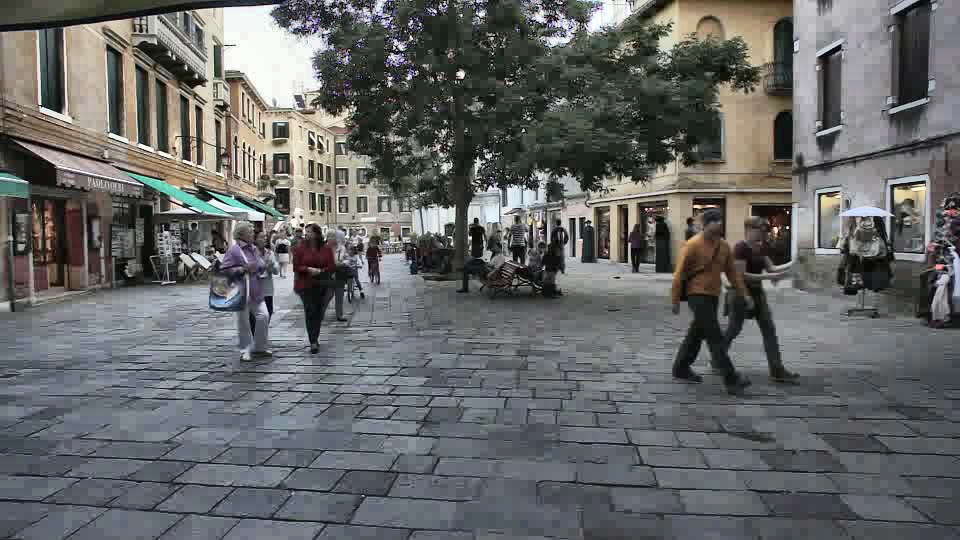

In [66]:
Image.fromarray(rgb)

In [41]:

from ByteTrack.yolox.data.data_augment import preproc
from ByteTrack.yolox.exp import get_exp
from ByteTrack.yolox.utils import fuse_model, get_model_info, postprocess
from ByteTrack.yolox.utils.visualize import plot_tracking
from ByteTrack.yolox.tracker.byte_tracker import BYTETracker
from ByteTrack.yolox.tracking_utils.timer import Timer


class ByteTrackPredictor(object):
    def __init__(
        self,
        model,
        exp,
        trt_file=None,
        decoder=None,
        device=torch.device("cpu"),
        fp16=False
    ):
        self.model = model
        self.decoder = decoder
        self.num_classes = exp.num_classes
        self.confthre = exp.test_conf
        self.nmsthre = exp.nmsthre
        self.test_size = exp.test_size
        self.device = device
        self.fp16 = fp16
        self.rgb_means = (0.485, 0.456, 0.406)
        self.std = (0.229, 0.224, 0.225)

    def inference(self, img):
        img_info = {"id": 0}
        if isinstance(img, str):
            img_info["file_name"] = os.path.basename(img)
            img = cv2.imread(img)
        else:
            img_info["file_name"] = None

        height, width = img.shape[:2]
        img_info["height"] = height
        img_info["width"] = width
        img_info["raw_img"] = img

        img, ratio = preproc(img, self.test_size, self.rgb_means, self.std)
        img_info["ratio"] = ratio
        img = torch.from_numpy(img).unsqueeze(0).float().to(self.device)
        if self.fp16:
            img = img.half()  # to FP16

        with torch.no_grad():
            outputs = self.model(img)
            if self.decoder is not None:
                outputs = self.decoder(outputs, dtype=outputs.type())
            outputs = postprocess(
                outputs, self.num_classes, self.confthre, self.nmsthre
            )

        return outputs, img_info



class ByteTrackArgs:
    def __init__(self) -> None:
        self.track_thresh = 0.5
        self.track_buffer = 30
        self.match_thresh = 0.8
        self.mot20 = False


exp_file = f'ByteTrack/exps/example/mot/yolox_x_mix_det.py'
ckpt_file = f'models/bytetrack_x_mot17.pth.tar'


exp = get_exp(exp_file, None)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = exp.get_model().to(device)
model.eval()

ckpt = torch.load(ckpt_file, map_location=str(device))
model.load_state_dict(ckpt["model"])

bytetrackpredictor = ByteTrackPredictor(model, exp, None, None, device, False)

bytetracker = BYTETracker(ByteTrackArgs(), frame_rate=30)

aspect_ratio_thresh = 1.6
min_box_area = 10

In [29]:

class ByteTrackPredictor(object):
    def __init__(
        self,
        model,
        exp,
        trt_file=None,
        decoder=None,
        device=torch.device("cpu"),
        fp16=False
    ):
        self.model = model
        self.decoder = decoder
        self.num_classes = exp.num_classes
        self.confthre = exp.test_conf
        self.nmsthre = exp.nmsthre
        self.test_size = exp.test_size
        self.device = device
        self.fp16 = fp16
        self.rgb_means = (0.485, 0.456, 0.406)
        self.std = (0.229, 0.224, 0.225)

    def inference(self, img):
        img, ratio = preproc(img, self.test_size, self.rgb_means, self.std)
        img = torch.from_numpy(img).unsqueeze(0).float().to(self.device)
        if self.fp16:
            img = img.half()  # to FP16

        with torch.no_grad():
            outputs = self.model(img)
            if self.decoder is not None:
                outputs = self.decoder(outputs, dtype=outputs.type())
            outputs = postprocess(
                outputs, self.num_classes, self.confthre, self.nmsthre
            )

        return outputs

bytetrackpredictor = ByteTrackPredictor(model, exp, None, None, device, False)

In [52]:
outputs, img_info = bytetrackpredictor.inference(rgb)
output_results = outputs[0].cpu().detach().numpy()
if output_results.shape[1] == 5:
    scores = output_results[:, 4]
    bboxes = output_results[:, :4]
else:
    scores = output_results[:, 4] * output_results[:, 5]
    bboxes = output_results[:, :4]  # x1y1x2y2
img_h, img_w = img_info['height'], img_info['width']
scale = min(exp.test_size[0] / float(img_h), exp.test_size[1] / float(img_w))
bboxes /= scale

In [53]:
bboxes

array([[     292.15,      223.38,      335.92,      354.84],
       [     222.39,       222.4,      275.74,      361.45],
       [     527.68,      241.31,      546.16,      297.77],
       [     668.34,      208.27,      752.11,      394.34],
       [      544.5,      241.06,      562.97,      299.84],
       [      549.3,      219.59,      568.65,      274.74],
       [     467.19,      217.39,      488.29,      275.67],
       [      274.6,      232.61,      291.14,       279.1],
       [     317.18,      229.74,      351.14,      324.44],
       [     709.23,      213.55,      800.77,      384.04],
       [     626.82,       223.3,      646.12,      273.99],
       [     508.19,      216.55,      528.29,       276.6],
       [     210.02,       228.8,      229.32,      273.47],
       [     289.78,       215.3,      300.54,      237.73],
       [     297.53,      214.85,      307.29,      236.24],
       [     240.39,      229.32,      276.82,      333.71],
       [      679.8,    

In [73]:
for bbox, conf in zip(bboxes, scores):
    if conf > 0.4:
        x1, y1, x2, y2 = bbox
        startX, startY, endX, endY = min(max(0,int(x1)), img_w-1), min(max(0,int(y1)),img_h-1), min(max(0,int(x2)), img_w-1), min(max(0,int(y2)),img_h-1)
        
        cv2.rectangle(rgb, (startX, startY), (endX, endY),(255, 100, 100), 2)

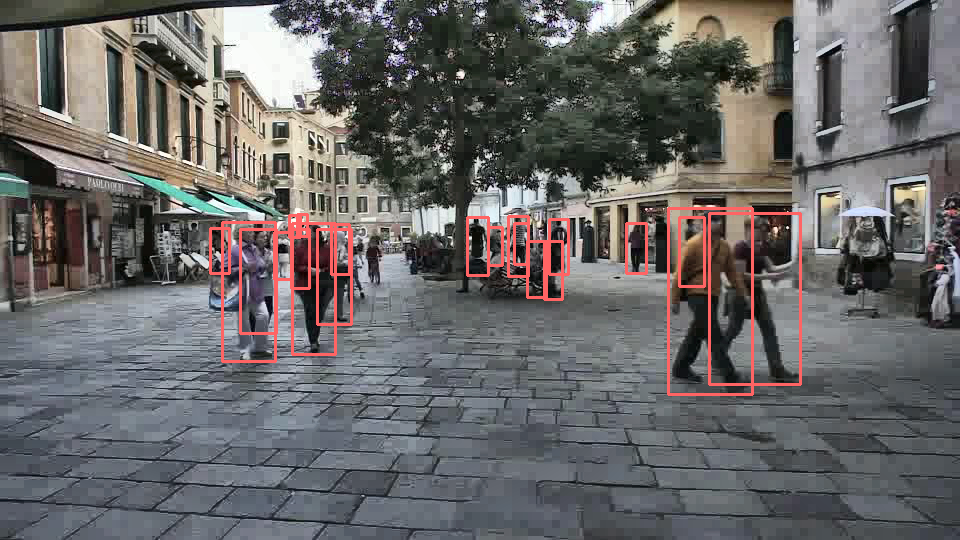

In [74]:
Image.fromarray(rgb)